In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame


%matplotlib widget

In [2]:
# freqs, dark_s21 = np.load('./VNAsweep.npy')
freqs, dark_s21 = np.load('.\S21s_2025318_15h32\S21_x23y0.npy')
M_pxs = 20
N_pxs = 20

Total:  393
Sufficiently spaced with  0.6 MHz:  329


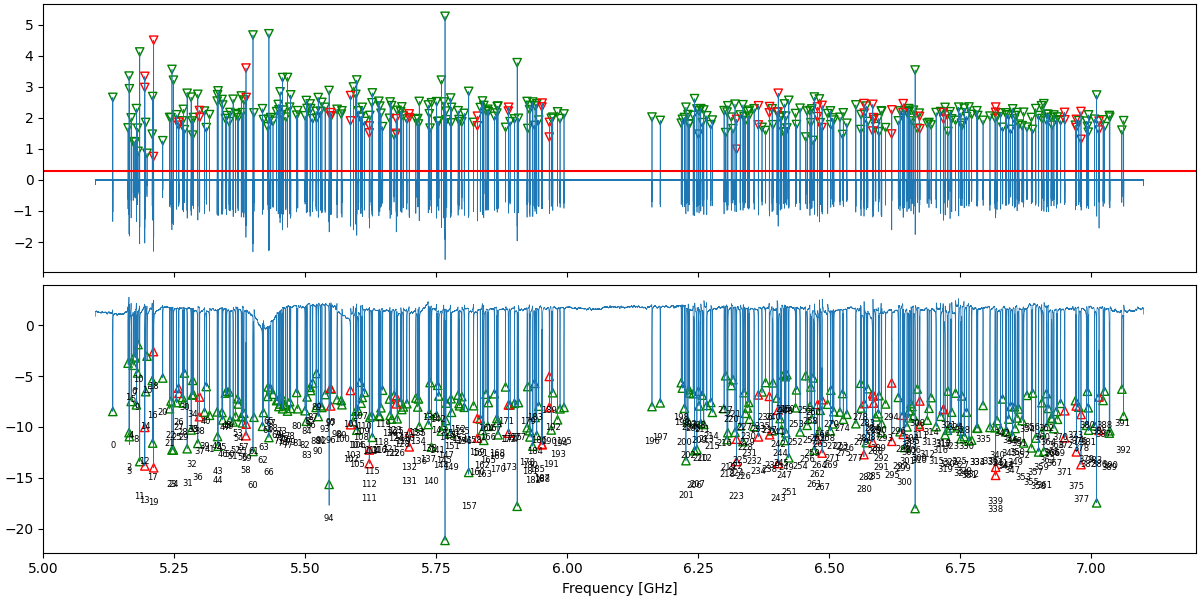

In [3]:
sw = 3 # even number
mph = 0.3
min_df = 0.0006
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']
locs += 1
f0s = freqs[locs]

df0s = f0s[1:] - f0s[:-1]
df_mask = np.zeros(f0s.shape, dtype=bool)
too_close = df0s < min_df
too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))

s21_mins = smooth_s21[locs]
fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[2:], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_s21, lw=.5)
ax['a'].axhline(mph, c='r')

ax['a'].scatter(freqs[locs[~too_close_mask]], heights[~too_close_mask], marker='v', c='None', edgecolor='g')
ax['b'].scatter(f0s[~too_close_mask], s21_mins[~too_close_mask], marker='^', c='None', edgecolor='g')
ax['a'].scatter(freqs[locs[too_close_mask]], heights[too_close_mask], marker='v', c='None', edgecolor='r')
ax['b'].scatter(f0s[too_close_mask], s21_mins[too_close_mask], marker='^', c='None', edgecolor='r')
for i, loc in enumerate(locs):
    ax['b'].annotate(f'{i}', (f0s[i], s21_mins[i]-5), textcoords="offset points", xytext=(0,10), ha='center', fontsize=6)
ax['b'].set_xlabel('Frequency [GHz]')
print('Total: ', len(locs))
print('Sufficiently spaced with ', min_df*1e3 , 'MHz: ', len(locs[~too_close_mask]))
# locs = locs[~too_close_mask]
# heights = heights[~too_close_mask]
# f0s = f0s[~too_close_mask]
# s21_mins = s21_mins[~too_close_mask]

In [4]:
files = natsorted(glob('.\S21s_2025318_15h32/*_*y0.npy'))[1:-2]
print(files)
nr_steps = len(files)
nr_kids = len(locs)
sweeps = np.empty((nr_steps, len(freqs)))
smoothed_sweeps = np.empty((nr_steps, len(freqs)))
s21s = np.empty((nr_steps, nr_kids))
s21s[:] = np.nan
smooth_dark_s21 = convolve(dark_s21, window, mode='same')
s0 = s21_mins
for i, file in enumerate(files):
    f, s21 = np.load(file)
    sweeps[i, :] = s21
    smooth_s21 = convolve(s21, window, mode='same')
    smoothed_sweeps[i, :] = smooth_s21
    s21s[i, :]  = smooth_s21[locs] - s0 

['.\\S21s_2025318_15h32\\S21_x2y0.npy', '.\\S21s_2025318_15h32\\S21_x3y0.npy', '.\\S21s_2025318_15h32\\S21_x4y0.npy', '.\\S21s_2025318_15h32\\S21_x5y0.npy', '.\\S21s_2025318_15h32\\S21_x6y0.npy', '.\\S21s_2025318_15h32\\S21_x7y0.npy', '.\\S21s_2025318_15h32\\S21_x8y0.npy', '.\\S21s_2025318_15h32\\S21_x9y0.npy', '.\\S21s_2025318_15h32\\S21_x10y0.npy', '.\\S21s_2025318_15h32\\S21_x11y0.npy', '.\\S21s_2025318_15h32\\S21_x12y0.npy', '.\\S21s_2025318_15h32\\S21_x13y0.npy', '.\\S21s_2025318_15h32\\S21_x14y0.npy', '.\\S21s_2025318_15h32\\S21_x15y0.npy', '.\\S21s_2025318_15h32\\S21_x16y0.npy', '.\\S21s_2025318_15h32\\S21_x17y0.npy', '.\\S21s_2025318_15h32\\S21_x18y0.npy', '.\\S21s_2025318_15h32\\S21_x19y0.npy', '.\\S21s_2025318_15h32\\S21_x20y0.npy', '.\\S21s_2025318_15h32\\S21_x21y0.npy']


total:  393


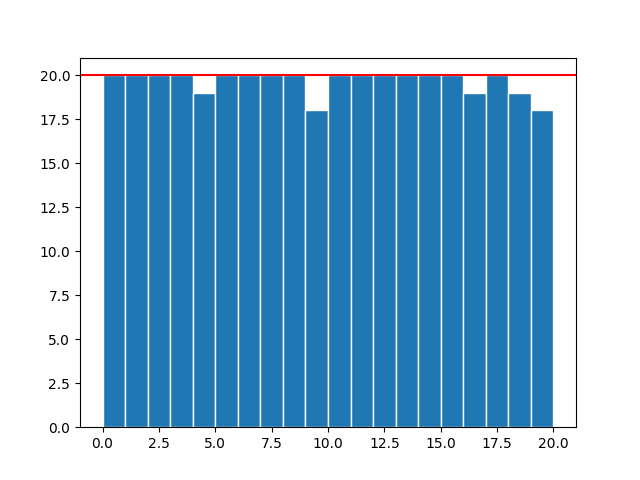

In [5]:
pos = np.empty((nr_kids)) # f0, 
pos[:] = np.nan
# pos[:, 0] = np.arange(nr_kids, dtype=int)
# pos[:, 1] = f0s
for i in range(nr_kids):
    maximum = np.nanmax(s21s[:, i])
    second_maximum = np.sort(s21s[:, i])[-2]
    minimum = np.nanmin(s21s[:, i])
    mean = (np.sum(s21s[:, i]) - maximum - minimum)/(nr_steps-2)
    maxprominence = maximum - mean
    secprominence =  second_maximum - mean
    if maxprominence < .4:
        print('low SNR: ', i)
    else: 
        pos[i] = np.nanargmax(s21s[:, i])
    # if secprominence > .9:
        # print('overlapping peak? ', int(pos[i, 0]))
pos[131] = 11
pos[223] = 7
pos[292] = 13
pos[294] = 16
pos[307] = 19
fig, ax = plt.subplots()
_ = ax.hist(pos, bins=np.arange(nr_steps+1), facecolor='tab:blue', edgecolor='w')
ax.axhline(M_pxs, c='r')
print('total: ', np.sum(~np.isnan(pos)))


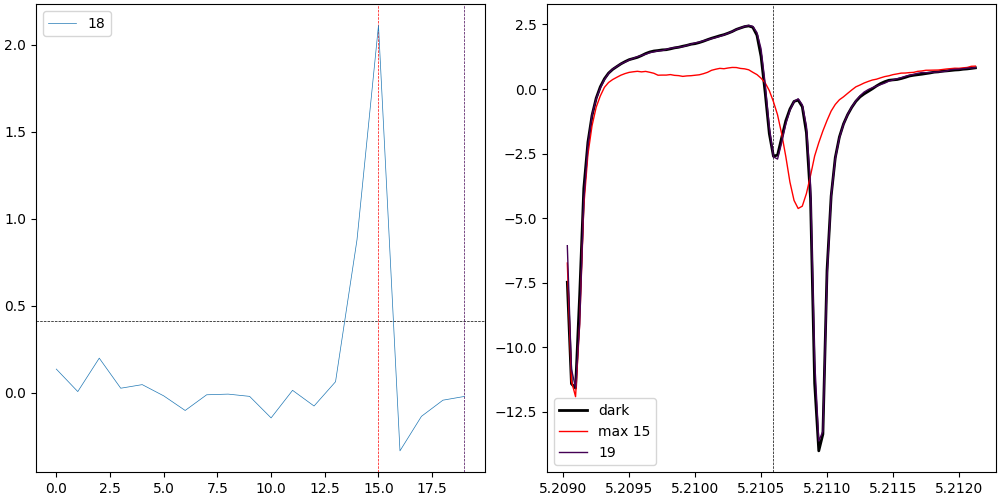

In [6]:
ids = [18]
fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
start = 0
stop = 20

steps = [19]
bw = 50
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for id in ids:
    maximum = np.nanmax(s21s[:, i])
    minimum = np.nanmin(s21s[:, i])
    mean = (np.sum(s21s[:, i]) - maximum - minimum)/(nr_steps-2)
    maxprominence = maximum - mean
    minprominence =  minimum - mean
    res = f0s[id]
    loc = locs[id]
    ax['a'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=2, c='k', label='dark')
    ax['a'].axvline(res, c='k', ls='--', lw=.5)
    ax['b'].axhline(mean, ls='--', lw=.5, c='k')
    ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[int(pos[id]), loc-bw:loc+bw], lw=1, label='max ' + str(int(pos[id])), c='r')
    ax['b'].axvline(pos[id], ls='--', lw=.5, c='r')

    for i, step in enumerate(steps):
        ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw], lw=1, label=str(step), c=colors[i])
        ax['b'].axvline(step, ls='--', lw=.5, c=colors[i])
    ax['b'].plot(s21s[:, id], lw=.5, label=str(id))
ax['b'].legend()
ax['a'].legend()

(16.0, 23.0)

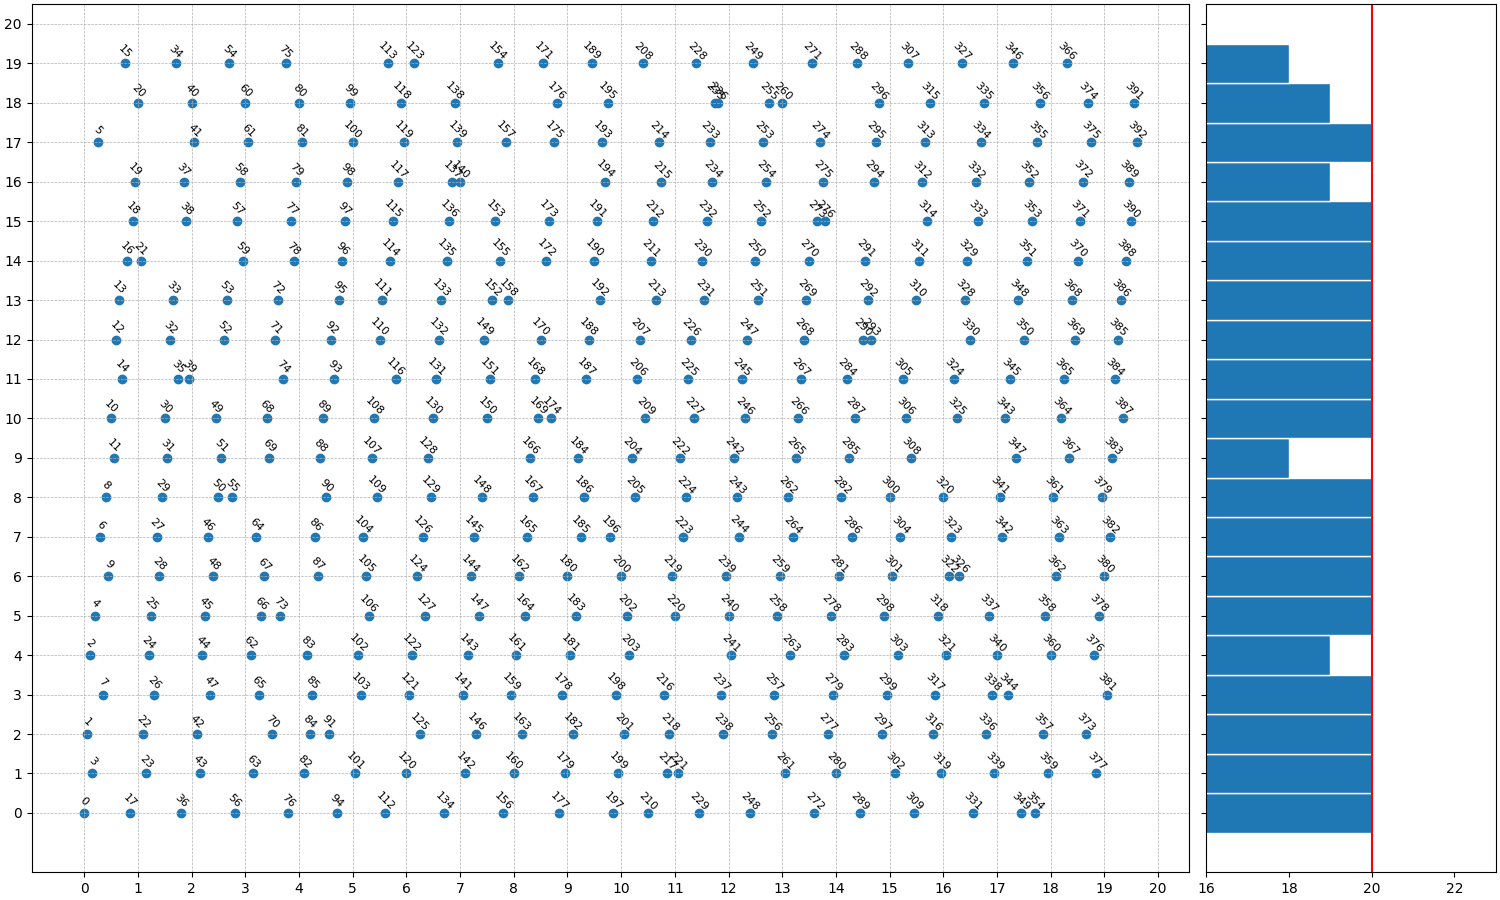

In [7]:
matrix = np.empty((M_pxs, N_pxs))
matrix[:] = np.nan
fig, ax = plt.subplot_mosaic('aaaab', figsize=(15,9), constrained_layout=True, sharey=True)   
x = np.arange(nr_kids)/M_pxs
ax['a'].scatter(x, pos, c='tab:blue')
for id, row in enumerate(pos):
    ax['a'].annotate(id, (x[id], row+.3), fontsize=8, ha='center', va='center', rotation=-45)
ax['a'].set_xticks(np.arange(0, M_pxs+1, 1))
ax['a'].set_yticks(np.arange(0, M_pxs+1, 1))
ax['a'].grid(True, which='both', linestyle='--', lw=.5)
ax['b'].hist(pos, bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['b'].axvline(M_pxs, c='r')
ax['b'].set_xlim([M_pxs-4, M_pxs+3])
# ax['a'].set_xlim([30,33])


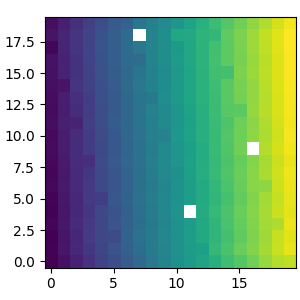

In [8]:
rows = [[] for _ in range(M_pxs)]
for id, row in enumerate(pos):
    if not np.isnan(row):
        rows[int(row)].append(int(id))
kids_derolled = np.empty((M_pxs, N_pxs))
kids_derolled[:] = np.nan   
for i, row in enumerate(rows):
    kids_derolled[i, :len(row)] = row
nans = [[4,11],
        [9,7],[9,16],
        [16,8],
        [18,7],
        [19,4],[19,19]]
for i, j in nans:
    kids_derolled[i, j+1:] = kids_derolled[i, j:-1]
    kids_derolled[i, j] = np.nan
kids_derolled[9, 7] = 146
kids_derolled[16, 8] = 176
kids_derolled[19, 4] = 94
kids_derolled[19, 19] = 384
# kids_derolled = np.flip(kids_derolled, axis=0)
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids_derolled, cmap='viridis', origin='lower')

[261. 280. 302. 319. 339. 359. 377.   3.  23.  43.  63.  82. 101. 120.
 142. 160. 179. 199. 217. 221.]


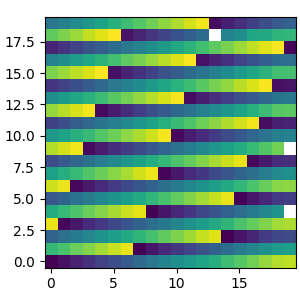

In [9]:
kids = copy(kids_derolled)
for i, row in enumerate(kids_derolled):
    kids[i] = np.roll(row, i*7)
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids, cmap='viridis', origin='lower')
print(kids[1])

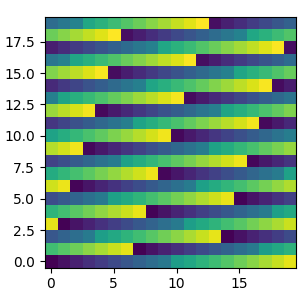

In [10]:
kid_id_board = np.load('kid_id_board_20x20.npy').astype(int)
finger_lengths = np.round(np.load('.\LT361_5-7GHz_400px_fingers.npy'),3)
design_f0s = np.load('LT361_5-7GHz_400px_F0s.npy')*1e-9
coupler_lengths = np.load('LT361_5-7GHz_400px_couplers.npy')
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(design_f0s[kid_id_board], cmap='viridis', origin='lower')

In [11]:
master_array = np.empty((M_pxs*N_pxs, 10)) # columns: idx, row, col, design finger, design couplers, design f0, meas f0, nibble design f0, nibble finger, nibble meas f0
master_array[:] = np.nan  
master_array[:,0] = np.arange(M_pxs*N_pxs)  
master_array[:,3] = finger_lengths
master_array[:,4] = coupler_lengths
master_array[:,5] = design_f0s
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        master_array[idx, 1] = i
        master_array[idx, 2] = j
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            master_array[idx, 6] = meas_f
design = master_array[:, 5]
meas = master_array[:, 6]
nanmask = np.isnan(meas)
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)
print(*master_array[0])

0.0 0.0 0.0 408.631 68.29551886755422 5.1000000000000005 5.132990206032583 nan nan nan


In [12]:
mux_array = master_array[:, 1:4]
mux_array[:, -1] = master_array[:, 6]
mux_array
# np.savetxt('mux_array.txt', mux_array, delimiter=' ', fmt='%d %d %1.4f')

array([[ 0.        ,  0.        ,  5.13299021],
       [ 1.        ,  7.        ,  5.16463706],
       [ 2.        , 14.        ,  5.16204408],
       ...,
       [17.        , 18.        ,  7.0622612 ],
       [18.        ,  5.        ,  7.05882472],
       [19.        , 12.        ,  7.01071401]])

line
0.002945628794611704


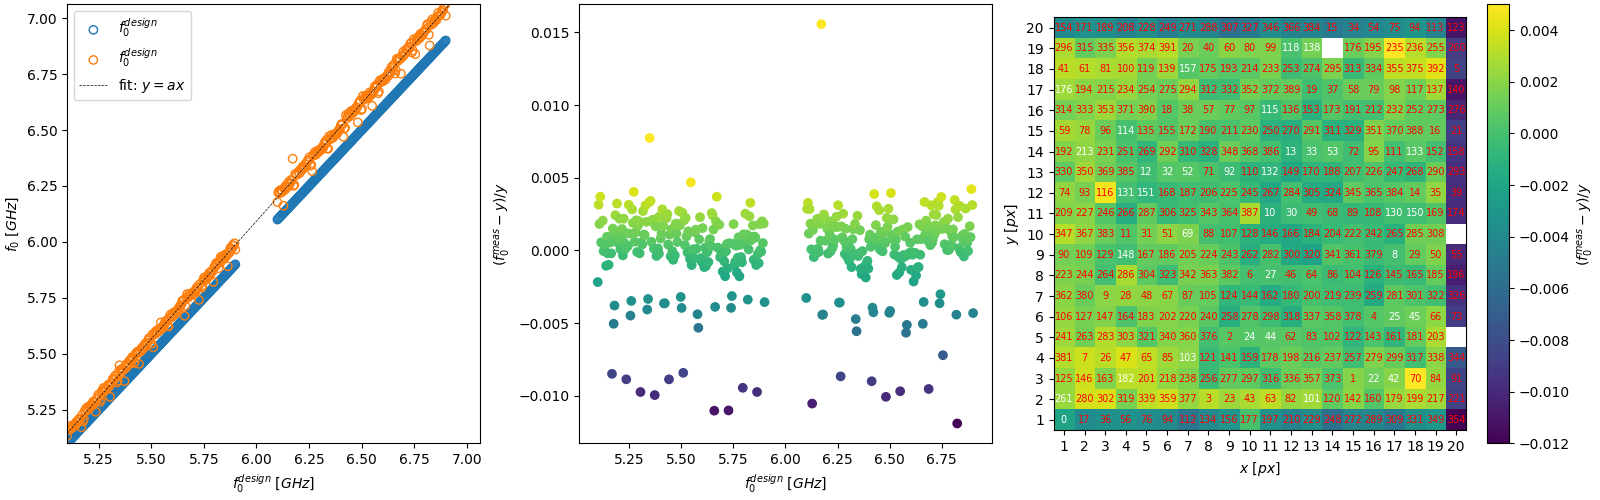

In [13]:
def linear(x, a, b):
    return a*x+b

def secorder(x, a, b, c):
    return a*x**2+b*x

line = linear
popt, pcov = curve_fit(line, design[~nanmask], meas[~nanmask])
design_fit = line(design, *popt)
df_f_fit = (meas - design_fit) / design_fit
df_f_map = df_f_fit[kid_id_board]
flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])

if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    print('line')
    popt, pcov = curve_fit(line, design[~nanmask], meas[~nanmask])
    fit = line(design, *popt)
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    fit = design
    label = 'f_0^{design}'
    save = 'nofit'
size=20

fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{design}$')
if line:
    ax['a'].plot(xfit, yfit, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim)
ax['a'].set_ylim(flim)
ax['a'].legend(loc='upper left')
clim = [-.012, .005]
ax['b'].scatter(design, df_f_fit, c=df_f_fit, vmin=clim[0], vmax=clim[1], label='residual, $f_0-y_2$')
# for i, x in enumerate(design):
#     ax['b'].annotate(i, (x, df_f_corr[i]), fontsize=8, ha='center', va='center')
ax['b'].annotate
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
        if ~np.isnan(y):
            old_id = kid_id_board[i, j]
            new_id = kids[i, j]
            if old_id == new_id:
                c = 'w'
            else:
                c = 'r'
            ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color=c)
# Major ticks
ax['c'].set_xticks(np.arange(0, size, 1))
ax['c'].set_yticks(np.arange(0, size, 1))
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, size+1, 1))
ax['c'].set_yticklabels(np.arange(1, size+1, 1))
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
# _ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
print(np.nanstd(df_f_fit))
# fig, ax = plt.subplots()
# ax.scatter(pos[:, -1], df_f_corr[np.argsort(meas)])

In [ ]:
fig, ax = plt.subplots()
_ = ax.hist(df_f_fit, bins=30)

In [37]:
nr_scans = 20

def map():
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    s21s[:, k] -= np.amin(s21s[:, k])
                    s21s[:, k] /= np.amax(s21s[:, k])
                    maps[i, j, nr] = s21s[nr, k]
                else:
                    maps[i, j, nr] = np.nan

    return maps

maps = map()

In [ ]:
start =10
fig, axes = plt.subplot_mosaic('abc;def',figsize=(12,8), constrained_layout=True)
for i, ax in enumerate(axes):
    ax = axes[ax]
    ax.imshow(maps[:, :, start+i], origin='lower', cmap='viridis')
    for i, x in enumerate(df_f_map):
        for j, y in enumerate(x):
                if ~np.isnan(y):
                    new_id = kids[i, j]
                    ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=6, color='r', rotation=45)
    _ =ax.set_xticks(np.arange(0, size, 1))
    _ =ax.set_yticks(np.arange(0, size, 1))
    # Labels for major ticks
    _ =ax.set_xticklabels(np.arange(1, size+1, 1))
    _ =ax.set_yticklabels(np.arange(1, size+1, 1))

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
            if ~np.isnan(y):
                new_id = kids[i, j]
                ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
ax.set_xticks(np.arange(0, size, 1))
ax.set_yticks(np.arange(0, size, 1))
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1))
ax.set_yticklabels(np.arange(1, size+1, 1))

def update(frame):
    cax.set_array(maps[:, :, frame])
    return cax,
ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
plt.show()
ani.save('animation_chip3.gif', writer='Pillow')


In [19]:
def rel_freqs(f0, oct, Q, nr_kids):
    Q_spacing = Q*(2**(oct/nr_kids)-1)
    powers = np.arange(nr_kids)
    f0s = f0 * (1+Q_spacing/Q)**powers
    return f0s

def rel_freqs(f0, fN, nr_kids):
    oct = np.log2(fN/f0)
    gamma = 2**(oct/nr_kids)
    powers = np.arange(nr_kids)
    f0s = f0 * gamma**powers
    return f0s

def lin_freqs(f0, fN, nr_kids):
    return np.linspace(f0, fN, nr_kids, endpoint=True)

def line(x, a, b):
    return a*x+b


In [ ]:
fig, ax = plt.subplots()
sorted_fs = meas[~nanmask][sort_idx]
ids = np.arange(len(meas))[~nanmask]
df = 0.003
nr_kids = len(sorted_fs)
nr_lower = 504
nr_upper = nr_kids - nr_lower
ax.scatter(ids, sorted_fs, label='measured (sorted)')
popt, pcov = curve_fit(line, ids[:nr_lower], sorted_fs[:nr_lower])
plot_ids_lower = np.arange(np.amax(ids[:nr_lower])+1)
ax.plot(plot_ids_lower, line(plot_ids_lower, *popt), label='fit lower')  
a_l, b_l = popt[0], popt[1]
popt, pcov = curve_fit(line, ids[nr_lower:], sorted_fs[nr_lower:])
plot_ids_upper = np.arange(np.amax(plot_ids_lower)+1, np.amax(ids)+1)
ax.plot(plot_ids_upper, line(plot_ids_upper, *popt), label='fit upper')  
a_u, b_u = popt[0], popt[1]
a = (a_l+a_u)/2+0.000075
nibble_lower = line(ids[:nr_lower], a, b_l)
diff_lower = sorted_fs[:nr_lower] - nibble_lower
argmax_diff_lower = np.argmax(sorted_fs[:nr_lower] - nibble_lower)
max_diff_lower = diff_lower[argmax_diff_lower]
nibble_lower += max_diff_lower + df
ax.scatter(ids[:nr_lower], nibble_lower, label='nibble lower')
nibble_upper = line(ids[nr_lower:], a, b_l)
diff_upper = sorted_fs[nr_lower:] - nibble_upper
argmax_diff_upper = np.argmax(sorted_fs[nr_lower:] - nibble_upper)
max_diff_upper = diff_upper[argmax_diff_upper]
nibble_upper += max_diff_upper + df
ax.scatter(ids[nr_lower:], nibble_upper, label='nibble upper')
ax.legend()

nibble_freqs = np.hstack((nibble_lower, nibble_upper))[inverse_sort_idx]
master_array[:, 7][~nanmask] = nibble_freqs

In [ ]:
fingers = master_array[:, 3]
ids  = master_array[:, 0]
trim_design = master_array[:, 7]

fig, axes = plt.subplot_mosaic('abcde', figsize=(15,3), constrained_layout=True)
ax = axes['a']
ax.scatter(design, fingers, label='design f')
ax.scatter(meas, fingers, label='meas f')
ax.scatter(trim_design, fingers, label='nibble f')
ax.set_ylabel('finger length [um]')
ax.set_xlabel('frequency [GHz]')

def poly(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3+d*x**2+e*x+f

popt, pcov = curve_fit(poly, meas[~nanmask], fingers[~nanmask])
fit_fingers = poly(meas, *popt)   
ax.plot(meas, fit_fingers, c='k', lw=1)	
new_fingers = poly(trim_design, *popt)
nibble_fingers = new_fingers+(fingers-fit_fingers)
# trims = copy(meas)
trims = nibble_fingers - fingers
ax.scatter(trim_design, nibble_fingers, c='r', lw=1, label='nibble f+trim')
ax.legend()

ax = axes['b']
ax.scatter(ids, trims)
ax.set_ylabel('kids')
ax.set_xlabel('f0 [GHz]')
print('minimum trim = %.3f um' % np.nanmax(trims))
print('maximum trim = %.3f um' % np.nanmin(trims))

ax = axes['c']
ax.scatter(design, design, label='original design')
ax.scatter(design, meas, label='measured')
ax.scatter(design, trim_design, label='nibble design')
ax.set_ylabel('freqency [GHz]')
ax.set_xlabel('design frequency [GHz]')
ax.legend()
ax = axes['d']
df = (trim_design[~nanmask][sort_idx][1:]-trim_design[~nanmask][sort_idx][:-1])*1e3
ax.plot(df)
ax.set_ylabel('Spacing df [GHz]')
ax.set_xlabel('kids')
ax = axes['e']
ax.imshow(trims[kid_id_board], origin='lower')

master_array[:, 8] = nibble_fingers

In [ ]:
trims = (master_array[:, 3] - master_array[:, 8])[kid_id_board]
trims[-6,0]


In [34]:
trims = master_array[:, 3] - master_array[:, 8]
np.save('LT361_chip8_trims.npy', trims[kid_id_board])
np.save('LT361_chip8_new_fingers.npy', master_array[:, 8])
np.save('LT361_chip8_master.npy', master_array)

In [34]:
N_fingers = 13 # number of IDC fingers
nr_fingers_cut = 7
finger_length = 111.# full length of the fingers

In [ ]:
nr_fingers = 7
finger_length = 111
max_cut = 104
original_fingers= master_array[:, 3]
nibbled_fingers = master_array[:, 8]
original_cut = nr_fingers*finger_length - original_fingers
nibbled_cut = nr_fingers*finger_length - nibbled_fingers
nibble_two_fingers = ((original_cut // max_cut) != (nibbled_cut // max_cut)).astype(float)
nibble_two_fingers[nanmask] = np.nan
too_little_room_at_start_finger = (nibbled_cut % max_cut < np.nanmax(trims)).astype(float)
too_little_room_at_start_finger[nanmask] = np.nan
both = ((nibble_two_fingers==1)!=(too_little_room_at_start_finger==0))
fig, ax = plt.subplot_mosaic('ab', figsize=(8,4))
ax['a'].imshow((too_little_room_at_start_finger)[kid_id_board], origin='lower')
ax['b'].imshow((nibble_two_fingers)[kid_id_board], origin='lower')

In [ ]:
kid = kid_id_board[31,0]
print('old finger cut: ', 777-original_fingers[kid], (777-original_fingers[kid])//max_cut, ' fingers', (777-original_fingers[kid])%max_cut, ' rem')
print('new finger cut: ', 777-nibbled_fingers[kid],(777-nibbled_fingers[kid])//max_cut, ' fingers', (777-nibbled_fingers[kid])%max_cut, ' rem')
print('trimmed length: ', trims[kid])

In [ ]:
nibbled_fingers[too_little_room_at_start_finger.astype(bool)]

In [ ]:
old = master_array[:, 3]
new = master_array[:, 8]
nr_fingers = 7
finger_length = 111
max_cut = 104
trim_width = 4.5
min_trim = 13

for i, nl in enumerate(new):
    if np.isnan(nl):
        nl = nr_fingers*max_cut
    ol = old[i]
    of = ol // max_cut
    nf = nl // max_cut
    rem = nl - nf*max_cut
    if of != nf:
        print('two')
        # place symbol min_trim (x=of, y=max_cut-trim_min)
    if rem < min_trim:
        print(rem)
        # make symbol rem
        # place symbol rem+dy (x=nf, y=-dy)
    else:
        print(rem)
        # place symbol min_trim (x=nf, y=rem-min_trim)
        


    